## Sustainability Report Analysis using pre-trained Models from HuggingFace
This notebook demonstrates how to classify environmental and action-related content from sustainability reports
using pre-trained language models from HuggingFace. The process involves extracting text from PDF reports, segmenting the text into sentences,
and classifying these sentences using pre-trained models.

The steps are as follows:
1. Install necessary packages.:
2. Load pre-trained models for classification.
3. Extract and segment text from PDFs.
4. Run the classification pipeline on sample reports.
5. Visualize the classification results.

Please set Runtime to GPU in Colab:

Go to the menu bar and select <b>Runtime</b> -->Choose <b>Change runtime type</b> -->Select <b>T4 GPU</b>

### Step1. Install packages and load the models

In [ ]:
# Install transformers
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import spacy

### Step2. Load pre-trained models from huggingface for classification


In [ ]:
# Load pre-trained model for environmental classification
env_model_name = "ESGBERT/EnvironmentalBERT-environmental"  # Path to model on Hugging Face
tokenizer_env = AutoTokenizer.from_pretrained(env_model_name)
model_env = AutoModelForSequenceClassification.from_pretrained(env_model_name)
pipe_env = pipeline("text-classification", model=model_env, tokenizer=tokenizer_env, device=0)  # Use GPU

# Load pre-trained model for action classification
action_model_name = "ESGBERT/EnvironmentalBERT-action"
tokenizer_act = AutoTokenizer.from_pretrained(action_model_name)
model_act = AutoModelForSequenceClassification.from_pretrained(action_model_name)
pipe_act = pipeline("text-classification", model=model_act, tokenizer=tokenizer_act, device=0)  # Use GPU

Device set to use cuda:0
Device set to use cuda:0


Test the classification models with some sentences:

In [ ]:
# "environmental" classification
pipe_env("We are really relying on people improving their consumer decisions to fight climate change.")

[{'label': 'environmental', 'score': 0.9977815747261047}]

In [ ]:
# "action" classification
pipe_act("We planted 7.500 trees in the last 5 years.")

[{'label': 'action', 'score': 0.9999480247497559}]

### Step3. PDF content extraction using semantic chunking with Unstructured.io.
The semantic chunking stage is time-consuming (taking around 2 minutes per page), so I used the processed reports from my previous project. The script, semantic_chunking.py, that I wrote for semantic chunking these reports is located in the same folder as this notebook.

### Step4. Run the classification pipeline on sample reports.
In this pipeline, we will first classify all sentences with the “environmental” model. Then, we will classify all “environmental” sentences with the “action” model.

In [ ]:
def classifyMultipleCompanies(json_file_paths, pipe_env, pipe_act):
    """
    Process multiple JSON files, classify sentences for environmental and action labels,
    and visualize results meaningfully using Plotly.

    Args:
    json_file_paths (list of str): List of file paths to JSON files for each company.
    pipe_env (pipeline): Hugging Face pipeline for environmental classification.
    pipe_act (pipeline): Hugging Face pipeline for action classification.

    Returns:
    pd.DataFrame: A DataFrame containing sentences and their classifications for all companies.
    """
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 2500000  # Increase max length for large documents

    all_results = []  # To store classification results for all companies

    for file_path in json_file_paths:
        # Load JSON file
        with open(file_path, 'r') as f:
            json_data = json.load(f)

        # Extract text for the company
        company_name = json_data[0]['metadata']['filename'].split('_')[0]  # Use part of the filename as company name
        company_text = " ".join([entry["text"] for entry in json_data])

        # Segment text into sentences
        about_doc = nlp(company_text)
        sentences = [str(sent).replace("\n", "").strip() for sent in about_doc.sents if sent.text.strip()]

        # Classify sentences as environmental
        env_classifications = pipe_env(sentences, padding=True, truncation=True, batch_size=16)
        env_labels = [x["label"] for x in env_classifications]
        df = pd.DataFrame({"text": sentences, "environmental": env_labels})

        # Filter environmental sentences and classify actions
        df_env = df.loc[df["environmental"] == "environmental"].copy()
        if not df_env.empty:
            action_classifications = pipe_act(df_env.text.to_list(), padding=True, truncation=True, batch_size=16)
            df_env["action"] = [x["label"] for x in action_classifications]
        else:
            df_env["action"] = None

        # Merge action results back into the main DataFrame
        df = df.merge(df_env[["text", "action"]], on="text", how="left")

        # Add company name to results
        df["company"] = company_name
        all_results.append(df)

    # Combine results for all companies into a single DataFrame
    combined_results = pd.concat(all_results, ignore_index=True)
    return combined_results

In [ ]:
results = classifyMultipleCompanies(json_file_paths, pipe_env, pipe_act)

In [ ]:
results

,text,environmental,action,company
0,y 3 t i 2 l i 0 b 2 a n t i r...,environmental,none,ABB
1,The ABB Way21,none,NaN,ABB
2,We enable a low-carbon society08 Sustainabilit...,environmental,none,ABB
3,We promote social progress44 Health and safety...,none,NaN,ABB
4,We embed a culture of integrity and transparen...,environmental,none,ABB
...,...,...,...,...
13318,Information about absolute changes between rep...,none,NaN,UBS
13319,"Tables | Within tables, blank fields generally...",none,NaN,UBS
13320,Zero values generally indicate that the respec...,none,NaN,UBS
13321,Percentage changes are presented as a mathemat...,none,NaN,UBS


#### Let's see:
 1. how much does the company talk about “environmental” topics in general and
 2. how much does it talk about “environmental actions”?

In [ ]:
def calculatePercentages(classified_df, output_csv="percentages_summary.csv"):
    """
    Calculate percentages of sentences addressing environmental topics and actions for each company
    and save the results to a CSV file.

    Args:
    classified_df (pd.DataFrame): DataFrame containing sentences and their classifications for all companies.
    output_csv (str): Path to save the summary results as a CSV file.

    Returns:
    pd.DataFrame: A DataFrame summarizing percentages for each company.
    """
    percentages = []  # To store percentage calculations

    # Group by company to calculate percentages for each company
    grouped = classified_df.groupby("company")
    for company_name, group in grouped:
        total_sentences = group.shape[0]
        env_sentences = group[group["environmental"] == "environmental"].shape[0]
        action_sentences = group[group["action"] == "action"].shape[0]

        # Calculate percentages
        env_pct = env_sentences / total_sentences if total_sentences > 0 else 0
        action_pct = action_sentences / total_sentences if total_sentences > 0 else 0

        # Append results to the list
        percentages.append({
            "company": company_name,
            "total_sentences": total_sentences,
            "environmental_sentences": env_sentences,
            "action_sentences": action_sentences,
            "environmental_percentage": env_pct,
            "action_percentage": action_pct,
        })

    # Convert the results into a DataFrame
    summary_df = pd.DataFrame(percentages)

    # Save to CSV
    summary_df.to_csv(output_csv, index=False)
    print(f"Percentages saved to {output_csv}")

    return summary_df


In [ ]:
summary_df = calculatePercentages(results, output_csv="classification_percentages.csv")
print(summary_df)

Percentages saved to classification_percentages.csv
  company  total_sentences  environmental_sentences  action_sentences  \
0     ABB             4365                     1988               628   
1    Coop             2261                      239                55   
2  Migros             1378                       75                33   
3     UBS             5319                     3224              1104   

   environmental_percentage  action_percentage  
0                  0.455441           0.143872  
1                  0.105705           0.024326  
2                  0.054427           0.023948  
3                  0.606129           0.207558  


### Step5. Visualize the classification results.

In [ ]:
def visualizePercentages(summary_df):
    """
    Visualize the percentages of environmental and environmental action sentences
    for multiple companies using predefined colors, white background, and Times New Roman font.

    Args:
    summary_df (pd.DataFrame): DataFrame summarizing percentages for each company.
    """
    # Extract data for visualization
    categories = summary_df['company'].tolist()
    values1 = summary_df['environmental_percentage'].tolist()
    values2 = summary_df['action_percentage'].tolist()

    bar_width = 0.30

    # Set the positions of the bars on the x-axis
    r1 = np.arange(len(categories))
    r2 = [x + bar_width for x in r1]

    # Define colors
    color1 = "#FFC845"  # Blue (environmental)
    color2 = "#3062FF"  # Green (environmental action)

    # Create traces
    trace1 = go.Bar(
        x=categories,
        y=values1,
        name='Environmental',
        marker_color=color1
    )

    trace2 = go.Bar(
        x=categories,
        y=values2,
        name='Environmental Action',
        marker_color=color2
    )

    # Create the layout
    layout = go.Layout(
        title=dict(
            text='Environmental and Action Percentages by Company',
            font=dict(family='Times New Roman', size=20)
        ),
        barmode='group',
        xaxis=dict(
            title='Company',
            titlefont=dict(family='Times New Roman', size=16),
            tickfont=dict(family='Times New Roman', size=14)
        ),
        yaxis=dict(
            title='Percentages',
            titlefont=dict(family='Times New Roman', size=16),
            tickfont=dict(family='Times New Roman', size=14),
            tickformat=".0%",
            showgrid=True,
            gridcolor='lightgrey',
            gridwidth=0.5
        ),
        legend=dict(
            title=dict(
                font=dict(family='Times New Roman', size=14)
            ),
            font=dict(family='Times New Roman', size=12)
        ),
        paper_bgcolor='white',  # White background
        plot_bgcolor='white'
    )

    fig = go.Figure(data=[trace1, trace2], layout=layout)

    fig.show()

In [ ]:
visualizePercentages(summary_df)

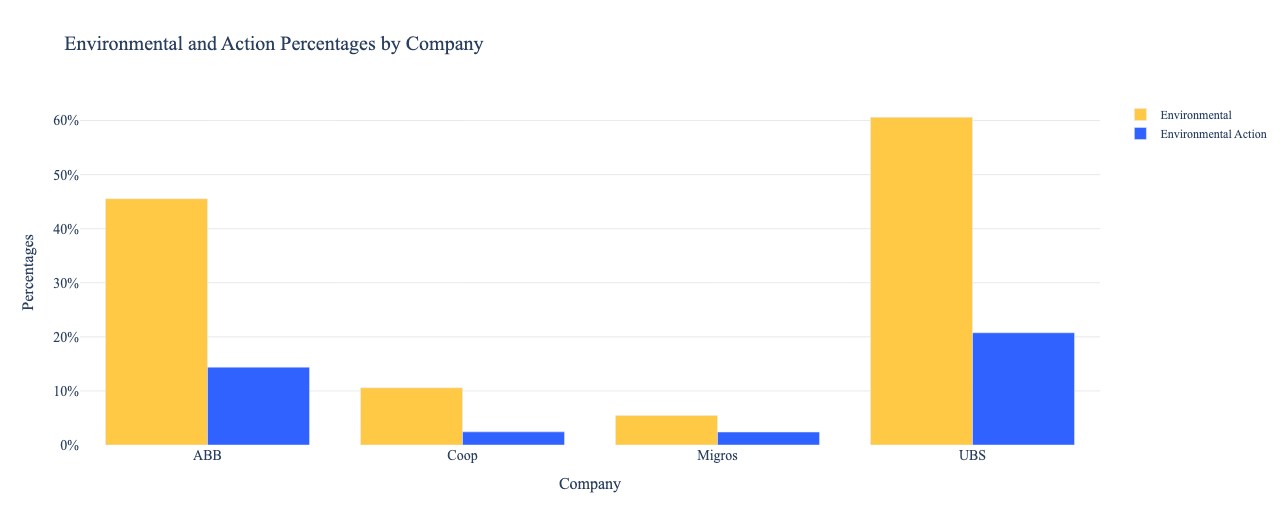

As shown in figure above, both UBS and ABB's reports contain a much higher proportion of sentences addressing both environmental topics and environmental actions compared to the reports from Coop and Migros.

Additionally, there is a consistent gap between the coverage of environmental topics and the focus on environmental actions across all four reports. This suggests that while all companies discuss environmental issues, fewer sentences are dedicated to detailing specific actions being taken.